## Task1: Basics

In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision
import torchvision.transforms as transforms
import numpy as np
import json
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt

In [19]:
pretrained_model = torchvision.models.resnet34(pretrained=True)
pretrained_model

/home/harshamupparaju/Softwares/anaconda3/envs/DL/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/harshamupparaju/Softwares/anaconda3/envs/DL/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [20]:
class ImageFolderWithPaths(ImageFolder):
    def __getitem__(self, index):
        image, label = super().__getitem__(index)
        path, _ = self.samples[index]
        filename = Path(path).stem
        return image, label, filename

In [21]:
# Preprocess the images

mean_norms = np.array([0.485, 0.456, 0.406])
std_norms = np.array([0.229, 0.224, 0.225])

plain_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean_norms,
                            std=std_norms)
])

root_path = Path("./data/")
dataset_path = root_path / "TestDataSet/"
dataset = ImageFolderWithPaths(root=dataset_path,
                                            transform=plain_transforms)

def update_labels(dataset):
    # Add 401 to the labels of images
    for i in range(len(dataset)):
        dataset.samples[i] = (dataset.samples[i][0], dataset.samples[i][1] + 401)

update_labels(dataset)

# Create a DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=0)

In [22]:
dataset[0]

(tensor([[[-1.2445, -0.7822, -0.7822,  ...,  0.1254, -0.4054, -0.2856],
          [-1.1589, -1.0048, -0.7650,  ...,  0.2796, -0.3712, -0.4226],
          [-0.9363, -1.1075, -0.7993,  ...,  0.0569, -0.5596, -0.6623],
          ...,
          [-2.0837, -2.0837, -2.0837,  ..., -0.0287, -0.6623, -0.7137],
          [-2.0837, -2.0837, -2.0837,  ..., -0.8507, -0.7993, -0.3541],
          [-2.0837, -2.0837, -2.0837,  ..., -0.3027, -0.2856,  0.0912]],
 
         [[-1.2479, -0.7752, -0.7752,  ...,  0.2227, -0.3200, -0.1975],
          [-1.1429, -0.9853, -0.7402,  ...,  0.3803, -0.2850, -0.3375],
          [-0.9153, -1.0903, -0.7752,  ...,  0.1527, -0.4776, -0.5826],
          ...,
          [-1.9657, -1.9657, -1.9657,  ...,  0.2227, -0.4251, -0.4776],
          [-1.9657, -1.9657, -1.9657,  ..., -0.6176, -0.5651, -0.1099],
          [-1.9657, -1.9657, -1.9657,  ..., -0.0574, -0.0399,  0.3452]],
 
         [[-1.4036, -0.9330, -0.9330,  ...,  0.2348, -0.3055, -0.1835],
          [-1.2641, -1.1073,

In [23]:
label_filepath = dataset_path / 'labels_list.json'
# /home/harshamupparaju/Documents/DL/jail-breaking-deep-models/TestDataSet/TestDataSet/labels_list.json
with open(label_filepath) as f:
    label_list = json.load(f)
    
#Make mapping
label_mapping = {}

for i in range(len(label_list)):
    s = label_list[i].split()
    label_mapping[int(s[0][:-1])] = s[1]

In [24]:
# Evaluate the model
def eval_model(model, dataloader, device):
    model.eval()
    
    model.to(device)
    top1_correct = 0
    top5_correct = 0

    total = len(dataset)

    with torch.no_grad():
        for images, labels, filenames in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            
            _, predicted = torch.max(outputs, 1)
            top1_correct += (predicted == labels).sum().item()
            # print(top1_correct)
            _, top5_predicted = torch.topk(outputs, 5)
            # print(top5_predicted)
            top5_correct += (top5_predicted == labels.unsqueeze(1)).sum().item()
        
        #Calculate accuracy
    top1_accuracy = top1_correct / total
    top5_accuracy = top5_correct / total

    return top1_accuracy, top5_accuracy


In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
top1_accuracy_original, top5_accuracy_original = eval_model(pretrained_model, dataloader, device)

print(f"Top-1 Accuracy on Original Images: {top1_accuracy_original * 100:.2f}%")
print(f"Top-5 Accuracy on Oriignal Images: {top5_accuracy_original * 100:.2f}%")

Top-1 Accuracy on Original Images: 76.00%
Top-5 Accuracy on Oriignal Images: 94.00%


## Task-2: Pixel-Wise Attacks

In [26]:
#Batch denormalize
def denormalize(batch, mean, std):
    mean = torch.tensor(mean).to(device)
    std = torch.tensor(std).to(device)
    return batch * std[:, None, None] + mean[:, None, None]

In [33]:
# Implement FGSM
epsilon = 0.02

fgsm_image_path = root_path / "AdversarialTestSet1"
fgsm_image_path.mkdir(parents=True, exist_ok=True)

def fgsm_attack(model, images, labels, epsilon):
    images.requires_grad = True
    outputs = model(images)
    model.zero_grad()
    loss = F.cross_entropy(outputs, labels)
    loss.backward()
    data_grad = images.grad.data
    # print(images)
    # print(f"Data grad shape: {data_grad.sign()}")
    # print(torch.max(images))
    # print(images[0])
    perturbed_images = denormalize(images, mean_norms, std_norms) + epsilon * data_grad.sign()
    # perturbed_images = torch.clamp(perturbed_images, -2.5, 2.5)
    # print(perturbed_images[0])
    # print(1/0)
    return perturbed_images

def save_adversarial_images(model, dataloader, epsilon):
    for images, labels, filenames in tqdm(dataloader):
        images = images.to(device)
        labels = labels.to(device)

        perturbed_images = fgsm_attack(model, images, labels, epsilon)
        perturbed_images = perturbed_images.cpu()

        for i in range(len(perturbed_images)):
            unique_image_name = filenames[i]
            image_path = fgsm_image_path / f'{labels[i].item()}/{unique_image_name}.JPEG'
            image_path.parent.mkdir(parents=True, exist_ok=True)
            print(images[i])
            print(perturbed_images[i])
            print(1/0)
            torchvision.utils.save_image(perturbed_images[i], image_path)
    return

save_adversarial_images(pretrained_model, dataloader, epsilon)



  0%|          | 0/16 [00:05<?, ?it/s]

tensor([[[-1.2445, -0.7822, -0.7822,  ...,  0.1254, -0.4054, -0.2856],
         [-1.1589, -1.0048, -0.7650,  ...,  0.2796, -0.3712, -0.4226],
         [-0.9363, -1.1075, -0.7993,  ...,  0.0569, -0.5596, -0.6623],
         ...,
         [-2.0837, -2.0837, -2.0837,  ..., -0.0287, -0.6623, -0.7137],
         [-2.0837, -2.0837, -2.0837,  ..., -0.8507, -0.7993, -0.3541],
         [-2.0837, -2.0837, -2.0837,  ..., -0.3027, -0.2856,  0.0912]],

        [[-1.2479, -0.7752, -0.7752,  ...,  0.2227, -0.3200, -0.1975],
         [-1.1429, -0.9853, -0.7402,  ...,  0.3803, -0.2850, -0.3375],
         [-0.9153, -1.0903, -0.7752,  ...,  0.1527, -0.4776, -0.5826],
         ...,
         [-1.9657, -1.9657, -1.9657,  ...,  0.2227, -0.4251, -0.4776],
         [-1.9657, -1.9657, -1.9657,  ..., -0.6176, -0.5651, -0.1099],
         [-1.9657, -1.9657, -1.9657,  ..., -0.0574, -0.0399,  0.3452]],

        [[-1.4036, -0.9330, -0.9330,  ...,  0.2348, -0.3055, -0.1835],
         [-1.2641, -1.1073, -0.8633,  ...,  0

ZeroDivisionError: division by zero

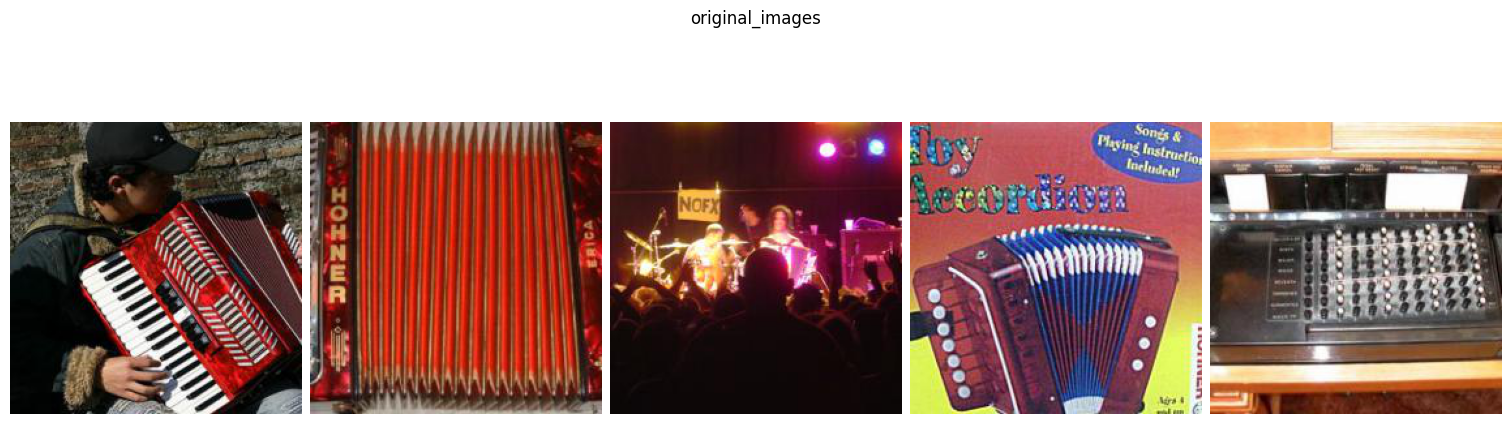

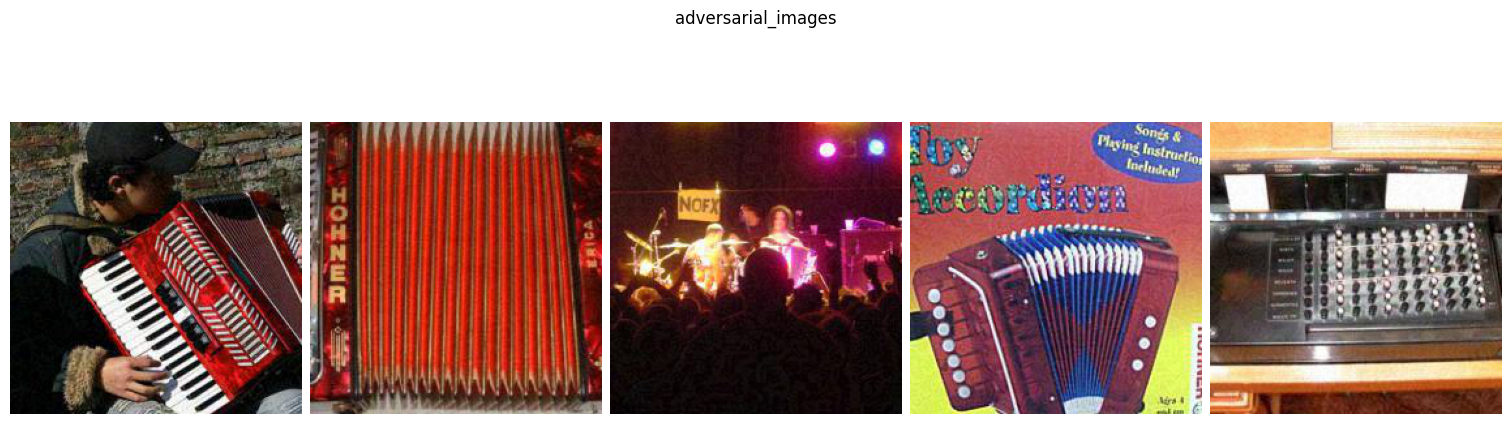

L-infinity norm for image 1: 0.3486
L-infinity norm for image 2: 0.2801
L-infinity norm for image 3: 0.4183
L-infinity norm for image 4: 0.2789
L-infinity norm for image 5: 0.3486


In [28]:
# Visualize images
fsgm_images_filepath = fgsm_image_path.glob("**/*.JPEG")
fsgm_images_filepath = list(fsgm_images_filepath)
fsgm_images_filepath = sorted(fsgm_images_filepath, key=lambda path: path.stem)

dataset_images_filepath = dataset_path.glob("**/*.JPEG")
dataset_images_filepath = list(dataset_images_filepath)
dataset_images_filepath = sorted(dataset_images_filepath, key=lambda path: path.stem)


def visualize_images(image_paths, title, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5), constrained_layout=True)
    for i, image_path in enumerate(image_paths[:num_images]):
        image = plt.imread(image_path)
        axes[i].imshow(image)
        axes[i].axis('off')
        
    fig.suptitle(title)
    #Remove the whitespace
    # plt.subplots_adjust()
    plt.show()

def calculate_l_inf_norm(original_image, adversarial_image):
    # Calculate the L-infinity norm
    l_inf_norm = torch.max(torch.abs(original_image - adversarial_image))
    return l_inf_norm.item()

# Visualize original images
original_image_paths = dataset_images_filepath
visualize_images(original_image_paths,'original_images', num_images=5)

# Visualize adversarial images
adversarial_image_paths = fsgm_images_filepath
visualize_images(adversarial_image_paths, 'adversarial_images', num_images=5)

# Calculate L-infinity norm for the first 5 images
l_inf_norms = []
for i in range(5):
    original_image = plt.imread(original_image_paths[i])
    adversarial_image = plt.imread(adversarial_image_paths[i])
    
    # Apply transdforms to the images
    original_image_tensor = plain_transforms(original_image)
    adversarial_image_tensor = plain_transforms(adversarial_image)
    
    l_inf_norm = calculate_l_inf_norm(original_image_tensor, adversarial_image_tensor)
    l_inf_norms.append(l_inf_norm)

# Print L-infinity norms
for i, l_inf_norm in enumerate(l_inf_norms):
    print(f"L-infinity norm for image {i+1}: {l_inf_norm:.4f}")


In [29]:
adversarial_image_dataset = ImageFolderWithPaths(root=fgsm_image_path, transform=plain_transforms)
update_labels(adversarial_image_dataset)
adversarial_dataloader = DataLoader(adversarial_image_dataset, batch_size=32, shuffle=False, num_workers=0)

# Evaluate the model on adversarial images

top1_accuracy_fgsm, top5_accuracy_fgsm = eval_model(pretrained_model, adversarial_dataloader, device)
print(f"Top-1 Accuracy on Adversarial Images: {top1_accuracy_fgsm * 100:.2f}%")
print(f"Top-5 Accuracy on Adversarial Images: {top5_accuracy_fgsm * 100:.2f}%")

Top-1 Accuracy on Adversarial Images: 6.20%
Top-5 Accuracy on Adversarial Images: 33.40%


In [30]:
device

device(type='cpu')

In [31]:
adversarial_image_dataset[0]

(tensor([[[-1.3815, -0.9192, -0.8507,  ...,  0.2111, -0.3027, -0.1828],
          [-1.2445, -1.0733, -0.7993,  ...,  0.3994, -0.2513, -0.2513],
          [-1.0562, -1.2103, -0.8507,  ...,  0.1768, -0.4397, -0.5082],
          ...,
          [-2.0323, -2.0494, -2.0837,  ..., -0.0287, -0.6623, -0.6965],
          [-2.0494, -2.0494, -2.0665,  ..., -0.8678, -0.8507, -0.3883],
          [-2.0494, -2.0494, -2.0494,  ..., -0.3883, -0.4054, -0.0287]],
 
         [[-1.2129, -0.7402, -0.7402,  ...,  0.1001, -0.4251, -0.3025],
          [-1.0378, -0.8978, -0.6527,  ...,  0.2927, -0.3725, -0.4251],
          [-0.7927, -1.0028, -0.6702,  ...,  0.0651, -0.5651, -0.6877],
          ...,
          [-1.9482, -1.9657, -2.0007,  ...,  0.2752, -0.3200, -0.3550],
          [-1.9657, -1.9657, -1.9832,  ..., -0.5826, -0.5126, -0.0399],
          [-1.9657, -1.9657, -1.9657,  ..., -0.0924, -0.0574,  0.3277]],
 
         [[-1.4210, -0.9504, -0.9330,  ...,  0.1651, -0.3578, -0.2358],
          [-1.2641, -1.1073,